# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2: Линейные модели


###### Общая информация

**Срок сдачи:** 05 апреля 18:00 Сдача **очная** на онлайн занятии.

Используйте данный Ipython Notebook при оформлении домашнего задания.

Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0920, Задание 2] Фамилия Имя.


**Штрафные баллы:**

1. Невыполнение PEP8
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со `stroykova_hw2.ipynb`)
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%load_ext pycodestyle_magic
%matplotlib inline

plt.rcParams['figure.figsize'] = (8, 5)

Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение

Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.

Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.

Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют **регуляризацией**. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической:
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК [академиком Тихоновым](https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова)

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.

Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Посчитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в MB)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается.
* Правило останова - максимальное количество эпох

# Теоретические вопросы (2 балла)

В этой части Вам будут предложены теоретические вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 

Формулы надо оформлять в формате **LaTeX**.
___

**Задача 1.** Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализируйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?

$$ w_{new} = w_{old} - \alpha \cdot (\frac{1}{n} \sum_{i=1}^n \nabla_w (\langle\,x_i, w_{old}\rangle - y_i)^2 + \frac{1}{C} \sum_{j=1}^D \nabla_w {w_{old}}_j^2) $$

$$ w_{new} = w_{old} - \alpha \cdot (\frac{2}{n} \sum_{i=1}^n (\langle\,x_i, w_{old}\rangle - y_i) x_i + \frac{2}{C} w_{old}) $$
___

**Задача 2.** Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

Подсказка: Вам градиент, которой получается если “в лоб” продифференцировать,  надо немного преобразовать.
Надо подставить, что $1 - \sigma(w,x) $ это  $1 - a(x_i)$, а  $-\sigma(w,x)$ это $0 - a(x_i)$.  Тогда получится свести к одной красивой формуле с линейной регрессией, которую программировать будет намного проще.

$$ a_i = \frac{1}{1 + e^{-\langle\,x_i, w\rangle}} $$
$$ w_{new} = w_{old} - \alpha \cdot  (- \frac{1}{n} \sum_{i=1}^n \nabla_w [y_i \log(a_i) + (1 - y_i) \log(1 - a_i)] + \frac{1}{C} \sum_{j=1}^D \nabla_w {w_{old}}_j^2) $$
$$ w_{new} = w_{old} - \alpha \cdot  (\frac{1}{n} \sum_{i=1}^n (a_i - y_i) x_i + \frac{2}{C} w_{old}) $$
___

**Задача 3.** Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^TY $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией. Как L2 регуляризация помогает с точным решением где матрица X имеет линейно зависимые признаки?

$$ \nabla_w [(2 X^T X) w - 2 X^T Y] > 0 $$
$$ (X^T X)^T > 0 $$
$$ X^T X > 0 $$

Зададим эрмитову форму $B$ вида $ B: \mathbb{R}^n \times \mathbb{R}^n \rightarrow \mathbb{R} $, где $\mathbb{R}$ $-$ поле вещественных чисел:
$$ B(x, y) = x^* X^T X y = x^T X^T X y $$
Число, сопряженное $B(x, y)$ будет равно
$$ B(x, y)^T = (x^T X^T X y)^T = (X y)^T (x^T X^T)^T = y^T X^T X x = B(y, x) $$
Значит, положительная определенность $X^T X$ зависит от положительной определенности билинейного отображения $B$, т.е.
$$ \forall x \neq 0 \in \mathbb{R}^n: B(x, x) > 0 \Rightarrow X^T X > 0 $$
при этом
$$ \forall x \neq 0 \in \mathbb{R}^n: B(x, x) = x^T X^T X x = (X x)^T (X x) = \langle\,X x, X x\rangle > 0 \Rightarrow X^T X > 0 $$

Точное решение с $L2$ регуляризацией:
$$ \nabla_w \frac{1}{N}(X w - y)^T (X w - y) + \beta w^T w = \frac{2}{N} (X^T X w - X^T y) + 2 \beta w = 0 $$
$$ (X^T X + I) w = X^T y \Rightarrow w = (X^T X + \lambda I)^{-1} X^T y $$
___

**Задача 4.**  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

Итак, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i))$$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определению мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

Сравним с нулем первую проиводную
$$ \nabla_a E(L | x_i) = \nabla_a [-p(y_i = 1 | x_i) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))] = 0 $$
$$ -p(y_i = 1 | x_i) \frac{1}{a(x_i)} - (1 - p(y_i = 1 | x_i)) \frac{-1}{1 - a(x_i)} = 0 $$
$$ (1 - p(y_i = 1 | x_i)) \frac{1}{1 - a(x_i)} = p(y_i = 1 | x_i) \frac{1}{a(x_i)} $$
$$ \frac{a(x_i)}{1 - a(x_i)} = \frac{p(y_i = 1 | x_i)}{1 - p(y_i = 1 | x_i)} \Rightarrow a(x_i) = p(y_i = 1 | x_i) $$

Проверим, что для найденного $a(x_i)$ выполняется неравенство
$$ \nabla_a [-p(y_i = 1 | x_i) \frac{1}{a(x_i)} - (1 - p(y_i = 1 | x_i)) \frac{-1}{1 - a(x_i)}] > 0 $$
$$ -p(y_i = 1 | x_i) \frac{-1}{a(x_i)^2} - (1 - p(y_i = 1 | x_i)) \frac{-1}{(1 - a(x_i))^2} > 0 $$
$$ \frac{1 - p(y_i = 1 | x_i)}{(a(x_i) - 1)^2} > -\frac{p(y_i = 1 | x_i)}{a(x_i)^2} \quad \blacksquare $$
___

**Задача 5.**  Смысл регуляризации.

Нужно ли в L1/L2 регуляризации использовать свободный член $w_0$ (который не умножается ни на какой признак)?

Подсказка: подумайте, для чего мы вводим $w_0$

$w_0$ задает предсказание в случае $w_i = 0, \space i = \overline{1, n}$. В некотором смысле $w_0$ выполняет роль вектора сдвига линейного афинного многообразия, поэтому если регуляризовать свободный член $w_0$, то решение будет неоправдано сдвигаться.
___

#  Реализация линейной модели (4 балла)

## Зачем нужны батчи?

Как Вы могли заметить из теоретического введения, что в случае SGD, что в случае mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам **не нужна вся выборка**. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчем).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными `np.array`.

## Немножко про генераторы в Python

Идея считывания данных кусками удачно ложится на так называемые **генераторы** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, **штрафоваться это никак не будет**. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот [тут](https://anandology.com/python-practice-book/iterators.html)

К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова `yield`. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [2]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например `enumerate`.

In [3]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print('Fib num: ' + str(j) + ' fib values: ' + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [4]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print('Fib num: ' + str(j) + ' fib values: ' + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [5]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print('Fib num: ' + str(j) + ' fib values: ' + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [6]:
from sklearn import utils


def batch_generator(X, y, shuffle=True, batch_size=1):
    if shuffle:
        X, y = utils.shuffle(X, y)
    for i in np.arange(0, X.shape[0], batch_size):
        yield (X[i:i + batch_size], y[i:i + batch_size])

In [7]:
%%flake8

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


from sklearn.base import BaseEstimator, ClassifierMixin


class MySGDClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, batch_generator, C=1, alpha=0.01, max_epoch=50, batch_size=25, model_type='lin_reg'):
        if model_type != 'lin_reg' and model_type != 'log_reg':
            raise ValueError('Unknown model type')

        self.batch_generator = batch_generator
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_size = batch_size
        self.model_type = model_type
        self.errors_log = {'iter': [], 'loss': []}

    def calc_loss(self, X_batch, y_batch):
        proba = X_batch.dot(self.weights)
        if self.model_type == 'lin_reg':
            error = proba - y_batch
            error = error.dot(error).sum()
        elif self.model_type == 'log_reg':
            proba = sigmoid(proba)
            error = ((y_batch - 1) * np.log(1 - proba) - y_batch * np.log(proba)).sum()
        loss = error / X_batch.shape[0] + self.weights.dot(self.weights) / self.C
        return loss

    def calc_loss_grad(self, X_batch, y_batch):
        proba = X_batch.dot(self.weights)
        if self.model_type == 'lin_reg':
            error = 2 * (proba - y_batch).dot(X_batch)
        elif self.model_type == 'log_reg':
            error = (sigmoid(proba) - y_batch).dot(X_batch)
        loss_grad = error / X_batch.shape[0] + 2 / self.C * self.weights
        return loss_grad

    def update_weights(self, new_grad):
        self.weights -= self.alpha * new_grad

    def fit(self, X, y):
        if isinstance(X, list):
            X = np.array(X)
        if isinstance(y, list):
            y = np.array(y)

        D = X.shape[1] + 1
        self.weights = np.random.uniform(-1 / D, 1 / D, D)
        alpha = self.alpha
        for n in np.arange(self.max_epoch):
            new_epoch_generator = self.batch_generator(X, y, batch_size=self.batch_size)
            for batch_num, (X_batch, y_batch) in enumerate(new_epoch_generator):
                X_batch = np.append(X_batch, np.ones((X_batch.shape[0], 1)), axis=1)
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.update_weights(self.calc_loss_grad(X_batch, y_batch))
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
            self.alpha = alpha / (n + 1)
        self.alpha = alpha
        return self

    def predict(self, X):
        X = np.append(X, np.ones((X.shape[0], 1)), axis=1)
        proba = X.dot(self.weights)
        if self.model_type == 'log_reg':
            proba = sigmoid(proba)
        y_hat = np.round(proba).astype('int')
        return y_hat

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков `X[:, 0]`, `X[:, 1]` для отображения в 2D пространство).  

In [8]:
def plot_decision_boundary(clf):
    x = np.linspace(-5, 8, num=2)
    y = (-clf.weights[0] * x - clf.weights[2]) / clf.weights[1]
    plt.plot(x, y, label=clf.model_type)

Linear regression weights:	[  50.98310228 -143.75063845 -414.72038987]

Logistic regression weights:	[ 0.97655889 -1.02161016 -4.28515439]


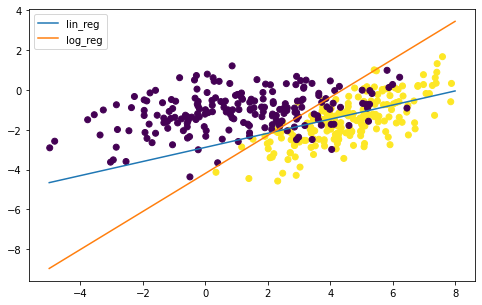

In [9]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

my_lin_clf = MySGDClassifier(batch_generator=batch_generator, C=1,
                             alpha=0.1, max_epoch=100, model_type='lin_reg')
my_lin_clf.fit(X, y)
print('Linear regression weights:\t{}'.format(my_lin_clf.weights), end='\n\n')
plot_decision_boundary(my_lin_clf)

my_log_clf = MySGDClassifier(batch_generator=batch_generator, C=10000,
                             alpha=10, batch_size=400, model_type='log_reg')
my_log_clf.fit(X, y)
print('Logistic regression weights:\t{}'.format(my_log_clf.weights))
plot_decision_boundary(my_log_clf)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.legend()

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [10]:
from sklearn.datasets import make_classification


X, y = make_classification(n_samples=100000, n_features=10,
                           n_informative=4, n_redundant=0,
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

(Text(0.5, 1.0, 'linear regression'), Text(0.5, 1.0, 'logistic regression'))

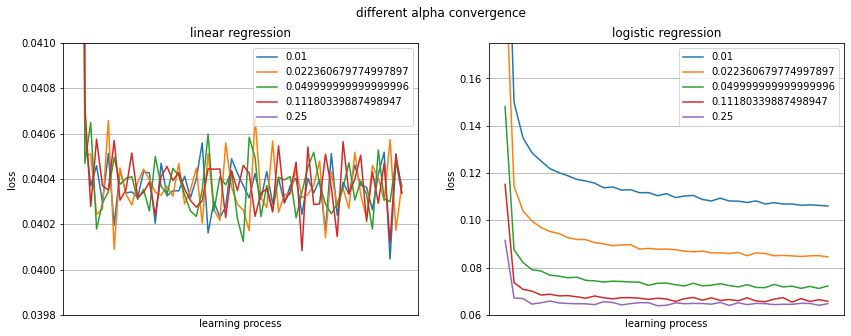

In [11]:
N = 500
fig, (lin_plot, log_plot) = plt.subplots(1, 2, figsize=(14, 5))
for alpha in np.geomspace(0.01, 0.25, 5):
    my_lin_clf = MySGDClassifier(batch_generator=batch_generator, C=10000, alpha=alpha,
                                 max_epoch=70, batch_size=250, model_type='lin_reg')
    my_log_clf = MySGDClassifier(batch_generator=batch_generator, C=10000, alpha=alpha,
                                 max_epoch=56, batch_size=300, model_type='log_reg')

    my_lin_clf.fit(X, y)
    lin_losses = np.asarray(my_lin_clf.errors_log['loss'])
    lin_x_axis = np.arange(lin_losses.shape[0] // N)
    lin_y_axis = list(map(np.mean, np.array_split(lin_losses, lin_losses.shape[0] // N)))
    lin_plot.plot(lin_x_axis, lin_y_axis, label=alpha)

    my_log_clf.fit(X, y)
    log_losses = np.asarray(my_log_clf.errors_log['loss'])
    log_x_axis = np.arange(log_losses.shape[0] // N)
    log_y_axis = list(map(np.mean, np.array_split(log_losses, log_losses.shape[0] // N)))
    log_plot.plot(log_x_axis, log_y_axis, label=alpha)

fig.suptitle('different alpha convergence')
lin_plot.grid(), log_plot.grid()
lin_plot.legend(), log_plot.legend()
lin_plot.set_xlabel('learning process'), log_plot.set_xlabel('learning process')
lin_plot.set_xticks([]), log_plot.set_xticks([])
lin_plot.set_ylabel('loss'), log_plot.set_ylabel('loss')
lin_plot.set_ylim(0.0398, 0.041), log_plot.set_ylim(0.06, 0.175)
lin_plot.set_title('linear regression'), log_plot.set_title('logistic regression')

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации $C$ из `np.logspace(3, -3, 10)` 

(Text(0.5, 1.0, 'linear regression'), Text(0.5, 1.0, 'logistic regression'))

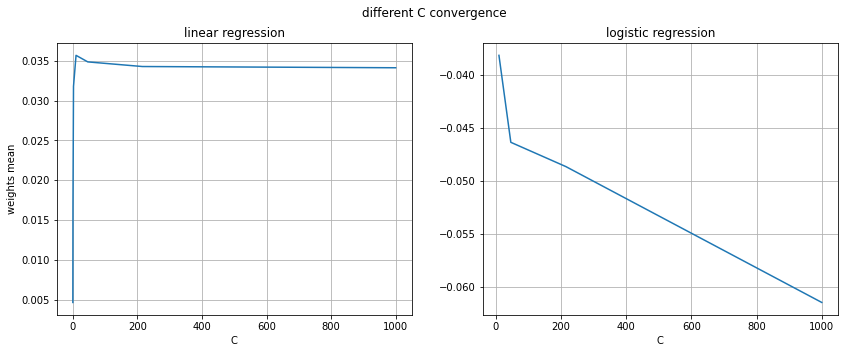

In [12]:
fig, (lin_plot, log_plot) = plt.subplots(1, 2)
x_axis = np.logspace(3, -3, 10)
lin_y_axis = np.empty(x_axis.shape[0])
log_y_axis = np.empty(x_axis.shape[0])
for i, C in enumerate(x_axis):
    my_lin_clf = MySGDClassifier(batch_generator=batch_generator, C=C, alpha=0.1,
                                 max_epoch=70, batch_size=250, model_type='lin_reg')
    my_log_clf = MySGDClassifier(batch_generator=batch_generator, C=C, alpha=10,
                                 max_epoch=56, batch_size=300, model_type='log_reg')

    my_lin_clf.fit(X, y)
    lin_y_axis[i] = my_lin_clf.weights.mean()

    my_log_clf.fit(X, y)
    log_y_axis[i] = my_log_clf.weights.mean()

fig.suptitle('different C convergence')
fig.set_figwidth(14)
lin_plot.plot(x_axis, lin_y_axis), log_plot.plot(x_axis, log_y_axis)
lin_plot.grid(), log_plot.grid()
lin_plot.set_xlabel('C'), log_plot.set_xlabel('C')
lin_plot.set_ylabel('weights mean')
lin_plot.set_title('linear regression'), log_plot.set_title('logistic regression')

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

# Боевое применение (4  балла)

**Защита данной части возможна только при преодолении в проекте бейзлайна Handmade baseline.**

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в `project_overview.ipynb`

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [13]:
from string import punctuation
from pymorphy2 import MorphAnalyzer

morph = MorphAnalyzer()


def preprocess_title(title):
    garbage = u'«®°»–—“”•…№→╬니동사의잡👍🔍' + punctuation
    mapping = dict.fromkeys(garbage)

    title = title.lower()
    title = title.translate(str.maketrans(mapping))
    title = list(map(lambda word: morph.parse(word)[0].normal_form, title.split()))
    title = ' '.join(title)
    return title.translate(str.maketrans({'ё': 'е'}))

In [14]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = preprocess_title(title)
len(doc_to_title)

28026

In [15]:
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import pdist, squareform

vectorizer = TfidfVectorizer()


X, y, groups = [], [], []
for group, docs in traingroups_titledata.items():
    doc_id, title, target = zip(*docs)
    distances = pdist(vectorizer.fit_transform(title).toarray(), 'cosine')
    distances[np.where(np.isnan(distances))[0]] = 1.
    features = np.sort(squareform(distances))[:, 1:26]
    X.extend(features)
    y.extend(target)
    groups.extend([group] * len(target))
X, y, groups = np.array(X), np.array(y), np.array(groups)

Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [17]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, GroupKFold

In [18]:
train_indices, test_indices = next(GroupKFold(n_splits=15).split(X, y, groups))
scaler = StandardScaler()
scaler.fit(X)

my_clf = MySGDClassifier(batch_generator=batch_generator, C=100000, alpha=0.0035,
                         max_epoch=20, batch_size=20, model_type='log_reg')
X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)
%time my_clf.fit(X_train, y_train)
f1_score(y_test, my_clf.predict(X_test))

CPU times: user 392 ms, sys: 7 µs, total: 392 ms
Wall time: 393 ms


0.7904191616766468

Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

In [19]:
cross_validation = GroupKFold(n_splits=5).split(X, y, groups)
my_clf = MySGDClassifier(batch_generator=batch_generator)
params = {
    'C': np.logspace(4, 7, 5),
    'alpha': np.geomspace(0.001, 0.1, 5),
    'max_epoch': np.linspace(50, 500, 5)
}
grid_search = GridSearchCV(my_clf, param_grid=params,
                           cv=cross_validation, n_jobs=-1)
%time grid_search.fit(X, y)

grid_search.best_params_

CPU times: user 5.28 s, sys: 128 ms, total: 5.41 s
Wall time: 8min 29s


{'C': 1778279.410038923, 'alpha': 0.03162277660168379, 'max_epoch': 275.0}

Подберите порог линейной модели, по достижении которого, Вы будете относить объект к классу 1. Вспомните, какую метрику мы оптимизируем в соревновании.  Как тогда правильно подобрать порог?

In [20]:
test_data = pd.read_csv('test_groups.csv')
testgroups_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    title = doc_to_title[doc_id]
    if doc_group not in testgroups_titledata:
        testgroups_titledata[doc_group] = []
    testgroups_titledata[doc_group].append((doc_id, title))

In [21]:
X_test, groups_test = [], []
for group, docs in testgroups_titledata.items():
    doc_id, title = zip(*docs)
    distances = pdist(vectorizer.fit_transform(title).toarray(), 'cosine')
    distances[np.where(np.isnan(distances))[0]] = 1.
    features = np.sort(squareform(distances))[:, 1:26]
    X_test.extend(features)
    groups_test.extend([group] * len(doc_id))
X_test, groups_test = np.array(X_test), np.array(groups_test)

In [22]:
from csv import DictWriter


a = grid_search.predict(X_test).flatten()
with open('submission.csv', 'w') as f:
    fieldnames = ['pair_id', 'target']
    writer = DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    i = 11691
    for elem in a:
        writer.writerow({'pair_id': str(i), 'target': str(elem)})
        i += 1

С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна.

**При сдаче домашки Вам необходимо кроме ссылки на ноутбук показать Ваш ник на kaggle, под которым Вы залили решение, которое побило Handmade baseline.**

[`thiranger`](https://www.kaggle.com/thiranger)

# Фидбек (бесценно)

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   